In [1]:
import os
import matplotlib.pyplot as plt
from zipfile import ZipFile
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image             
from keras_preprocessing.image import ImageDataGenerator  
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
os.environ['CONFIG_DIR'] ="datasetfix"

In [2]:
pwd

'd:\\Orbit\\Studi Independen\\Project Akhir\\Project bukan uji coba\\Sign-Language-RealTime -RepairDataset'

In [3]:
%cd datasetfix

d:\Orbit\Studi Independen\Project Akhir\Project bukan uji coba\Sign-Language-RealTime -RepairDataset\datasetfix


## Preprocessing

In [4]:
SignLanguageDetection = os.path.join('../datasetfix/')
print(os.listdir(SignLanguageDetection))

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [5]:
len(os.listdir(SignLanguageDetection))

26

In [6]:
SignLanguageDetection=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

In [7]:
for signlanguage in SignLanguageDetection:
    print(f'{signlanguage} images: ', len(os.listdir(f'../datasetfix/{signlanguage}')))

A images:  21
B images:  21
C images:  21
D images:  21
E images:  21
F images:  21
G images:  21
H images:  21
I images:  21
J images:  21
K images:  21
L images:  21
M images:  21
N images:  21
O images:  21
P images:  21
Q images:  21
R images:  21
S images:  21
T images:  21
U images:  21
V images:  21
W images:  21
X images:  21
Y images:  21
Z images:  21


In [8]:
train_folder = os.path.join('../datasetfix')
all_data = []
for folder in os.listdir(train_folder):
    label_folder = os.path.join(train_folder, folder)
    only_files = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    all_data += (only_files)

data = pd.DataFrame(all_data)
data


,label,path
0,A,../datasetfix\A\A.png
1,A,../datasetfix\A\A1.png
2,A,../datasetfix\A\A10.png
3,A,../datasetfix\A\A11.png
4,A,../datasetfix\A\A12.png
...,...,...
541,Z,../datasetfix\Z\Z5.png
542,Z,../datasetfix\Z\Z6.png
543,Z,../datasetfix\Z\Z7.png
544,Z,../datasetfix\Z\Z8.png


In [9]:
# train and test split
x_train, x_holdout = train_test_split(data, test_size=0.1, random_state=42, stratify=data[['label']])
x_train,x_test = train_test_split(x_train, test_size= 0.2, random_state=42,stratify=x_train[['label']])


### Image data generator

In [10]:
# BASIS_DIR = "../datasetfix/"
training_datagen = ImageDataGenerator(
    rescale = 1./255, 
    rotation_range=20,
    brightness_range=[0.2,1.0], 
    height_shift_range=0.1,
    shear_range=0.2, 
    zoom_range=0.1,  
    horizontal_flip=True,  
    fill_mode='nearest',
)

validation_datagen = ImageDataGenerator(rescale = 1./255)

holdout_datagen = ImageDataGenerator(rescale = 1./255)

In [11]:
y_col = 'label'
x_col = 'path'
no_of_classes = len(data[y_col].unique())

train_generator = training_datagen.flow_from_dataframe( 
    dataframe=x_train,  x_col=x_col, y_col=y_col, 
    target_size=(150,150), 
    class_mode='categorical', 
    shuffle=False,                                                               
    batch_size=128,
    
)


validation_generator = validation_datagen.flow_from_dataframe(      
    dataframe=x_holdout, x_col=x_col, y_col=y_col,      
    target_size=(150,150),      
    class_mode='categorical',
    shuffle=False,
    batch_size=128
)

holdout_generator = holdout_datagen.flow_from_dataframe(
    dataframe=x_holdout, x_col=x_col, y_col=y_col,
    target_size=(150, 150), 
    class_mode='categorical', 
    batch_size=128,
    shuffle=False
)


Found 392 validated image filenames belonging to 26 classes.
Found 55 validated image filenames belonging to 26 classes.
Found 55 validated image filenames belonging to 26 classes.


In [12]:
# Show the first batch of images

for batch, labels in train_generator:
    print(batch.shape)
    print(labels.shape)
    break
    
print()

for batch, labels in validation_generator:
    print(batch.shape)
    print(labels.shape)
    break

print()
for batch, labels in holdout_generator:
    print(batch.shape)
    print(labels.shape)
    break

(128, 150, 150, 3)
(128, 26)

(55, 150, 150, 3)
(55, 26)

(55, 150, 150, 3)
(55, 26)


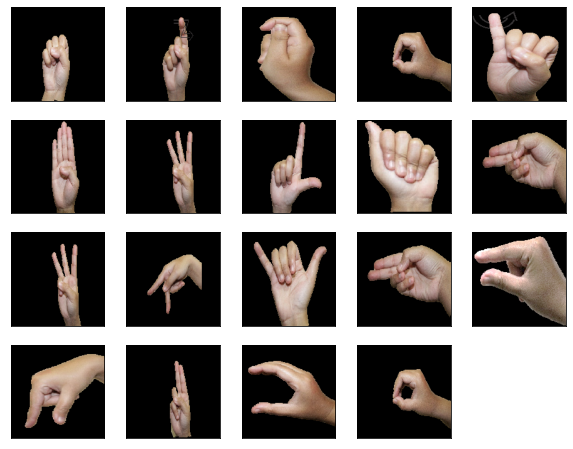

In [13]:
# Show images

plt.figure(figsize=(10,10))

for i in range(19):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(batch[i], cmap=plt.cm.binary)

In [14]:
# Adam
Adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

# RMSprop
RMSprop = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.7, epsilon=1e-08, decay=0.0)

## Modeling: CNN

### Optimizer Adam

In [15]:
model1 = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(26, activation='softmax')
         ])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [16]:
%%time
model1.compile(loss='categorical_crossentropy', optimizer=Adam, metrics=['accuracy'])
history1 = model1.fit(train_generator, epochs=20, validation_data=validation_generator, verbose=1)

Epoch 1/20
4/4 [==============================] - 21s 6s/step - loss: 3.2447 - accuracy: 0.0918 - val_loss: 3.1882 - val_accuracy: 0.0727
Epoch 2/20
4/4 [==============================] - 19s 4s/step - loss: 3.2118 - accuracy: 0.0867 - val_loss: 3.1163 - val_accuracy: 0.1091
Epoch 3/20
4/4 [==============================] - 19s 4s/step - loss: 3.1659 - accuracy: 0.0918 - val_loss: 3.0328 - val_accuracy: 0.0727
Epoch 4/20
4/4 [==============================] - 18s 6s/step - loss: 3.1051 - accuracy: 0.0944 - val_loss: 2.9477 - val_accuracy: 0.0727
Epoch 5/20
4/4 [==============================] - 20s 4s/step - loss: 3.0520 - accuracy: 0.1020 - val_loss: 2.8211 - val_accuracy: 0.1636
Epoch 6/20
4/4 [==============================] - 18s 4s/step - loss: 2.9932 - accuracy: 0.1276 - val_loss: 2.6535 - val_accuracy: 0.2000
Epoch 7/20
4/4 [==============================] - 19s 4s/step - loss: 2.9185 - accuracy: 0.1607 - val_loss: 2.4727 - val_accuracy: 0.2545
Epoch 8/20
4/4 [==================

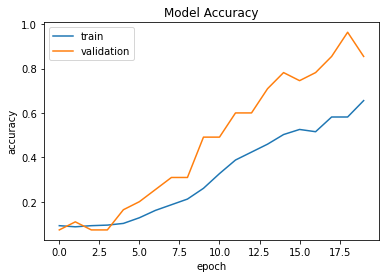

In [17]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

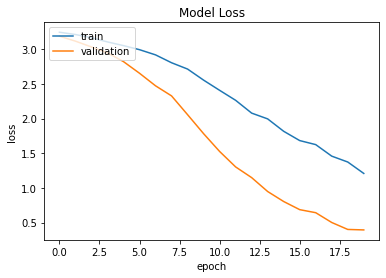

In [18]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Optimizer RMSprop

In [19]:
model3 = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
            tf.keras.layers.MaxPooling2D(2, 2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(26, activation='softmax')
         ])

model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 64)      

In [20]:
%%time
model3.compile(loss='categorical_crossentropy', optimizer=RMSprop , metrics=['accuracy'])
history3 = model3.fit(train_generator, epochs=20, validation_data=validation_generator, verbose=1)

Epoch 1/20
4/4 [==============================] - 21s 4s/step - loss: 3.2267 - accuracy: 0.0740 - val_loss: 3.1783 - val_accuracy: 0.0909
Epoch 2/20
4/4 [==============================] - 20s 4s/step - loss: 2.9582 - accuracy: 0.1684 - val_loss: 4.5625 - val_accuracy: 0.0364
Epoch 3/20
4/4 [==============================] - 20s 4s/step - loss: 2.9857 - accuracy: 0.1913 - val_loss: 2.7697 - val_accuracy: 0.2545
Epoch 4/20
4/4 [==============================] - 21s 4s/step - loss: 2.5751 - accuracy: 0.2500 - val_loss: 1.3963 - val_accuracy: 0.5818
Epoch 5/20
4/4 [==============================] - 21s 5s/step - loss: 2.1259 - accuracy: 0.4005 - val_loss: 0.9912 - val_accuracy: 0.7091
Epoch 6/20
4/4 [==============================] - 20s 6s/step - loss: 1.4559 - accuracy: 0.6148 - val_loss: 0.7854 - val_accuracy: 0.8545
Epoch 7/20
4/4 [==============================] - 20s 7s/step - loss: 1.6891 - accuracy: 0.5612 - val_loss: 0.4553 - val_accuracy: 0.8182
Epoch 8/20
4/4 [==================

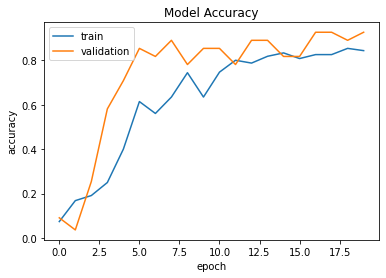

In [21]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

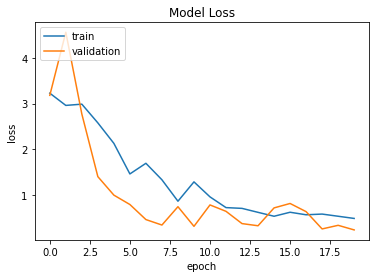

In [22]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Modeling: Transfer Learning MobileNetV2

In [23]:
img_size = 128
img_shape = (img_size, img_size, 3)

model_mobilenetV2 = tf.keras.applications.MobileNetV2(input_shape=img_shape, include_top=False, weights='imagenet')
model_mobilenetV2.trainable = False

In [24]:
model_mobilenetV2.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

### Optimizer RMSProp

In [25]:
mobilenetV2_model = tf.keras.models.Sequential([
                        model_mobilenetV2,
                        tf.keras.layers.Flatten(),
                        tf.keras.layers.Dense(128, activation='relu'),
                        tf.keras.layers.Dense(64, activation='relu'),
                        tf.keras.layers.Dense(32, activation='relu'),
                        tf.keras.layers.Dense(32, activation='relu'),
                        tf.keras.layers.Dense(26, activation='softmax')
                    ])

mobilenetV2_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_2 (Flatten)         (None, 20480)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               2621568   
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dense_7 (Dense)             (None, 32)                1056      
                                                      

In [26]:
%%time
mobilenetV2_model.compile(loss='categorical_crossentropy', optimizer=RMSprop , metrics=['accuracy'])
history4 = mobilenetV2_model.fit(train_generator, epochs=20, validation_data=validation_generator, verbose=1)


Epoch 1/20
4/4 [==============================] - 31s 4s/step - loss: 5.0853 - accuracy: 0.0561 - val_loss: 3.8709 - val_accuracy: 0.0727
Epoch 2/20
4/4 [==============================] - 16s 4s/step - loss: 3.5435 - accuracy: 0.0612 - val_loss: 3.1612 - val_accuracy: 0.1091
Epoch 3/20
4/4 [==============================] - 16s 5s/step - loss: 3.0061 - accuracy: 0.1403 - val_loss: 2.7379 - val_accuracy: 0.2364
Epoch 4/20
4/4 [==============================] - 15s 3s/step - loss: 2.9254 - accuracy: 0.1658 - val_loss: 2.7386 - val_accuracy: 0.2182
Epoch 5/20
4/4 [==============================] - 17s 4s/step - loss: 2.4949 - accuracy: 0.2423 - val_loss: 2.6775 - val_accuracy: 0.2364
Epoch 6/20
4/4 [==============================] - 15s 3s/step - loss: 2.4834 - accuracy: 0.2449 - val_loss: 2.6793 - val_accuracy: 0.2364
Epoch 7/20
4/4 [==============================] - 15s 4s/step - loss: 2.3136 - accuracy: 0.3265 - val_loss: 2.0324 - val_accuracy: 0.4364
Epoch 8/20
4/4 [==================

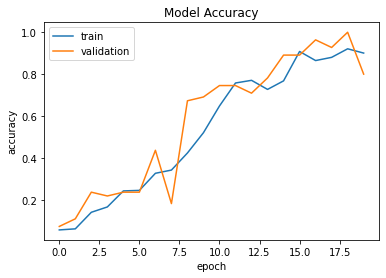

In [27]:
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

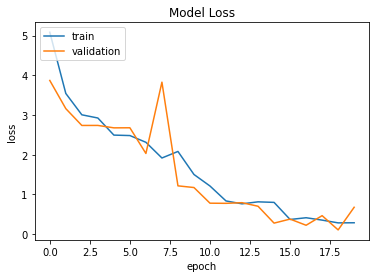

In [28]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Optimizer Adam

In [29]:
mobilenetV2_model2 = tf.keras.models.Sequential([
                        model_mobilenetV2,
                        tf.keras.layers.Flatten(),
                        tf.keras.layers.Dense(128, activation='relu'),
                        tf.keras.layers.Dense(64, activation='relu'),
                        tf.keras.layers.Dense(32, activation='relu'),
                        tf.keras.layers.Dense(32, activation='relu'),
                        tf.keras.layers.Dense(26, activation='softmax')
                    ])

mobilenetV2_model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_3 (Flatten)         (None, 20480)             0         
                                                                 
 dense_9 (Dense)             (None, 128)               2621568   
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 32)                2080      
                                                                 
 dense_12 (Dense)            (None, 32)                1056      
                                                      

In [30]:
%%time
mobilenetV2_model2.compile(loss='categorical_crossentropy', optimizer=Adam, metrics=['accuracy'])
history5 = mobilenetV2_model2.fit(train_generator, epochs=20, validation_data=validation_generator, verbose=1)

Epoch 1/20
4/4 [==============================] - 22s 4s/step - loss: 3.3417 - accuracy: 0.0434 - val_loss: 3.2132 - val_accuracy: 0.0364
Epoch 2/20
4/4 [==============================] - 15s 3s/step - loss: 3.1107 - accuracy: 0.0791 - val_loss: 2.8423 - val_accuracy: 0.1273
Epoch 3/20
4/4 [==============================] - 15s 3s/step - loss: 2.8337 - accuracy: 0.1505 - val_loss: 2.6043 - val_accuracy: 0.2000
Epoch 4/20
4/4 [==============================] - 17s 4s/step - loss: 2.4908 - accuracy: 0.2398 - val_loss: 2.3633 - val_accuracy: 0.2364
Epoch 5/20
4/4 [==============================] - 19s 5s/step - loss: 2.2760 - accuracy: 0.3265 - val_loss: 2.1501 - val_accuracy: 0.3818
Epoch 6/20
4/4 [==============================] - 18s 4s/step - loss: 2.0185 - accuracy: 0.3827 - val_loss: 1.8341 - val_accuracy: 0.4545
Epoch 7/20
4/4 [==============================] - 18s 4s/step - loss: 1.7738 - accuracy: 0.4592 - val_loss: 1.6479 - val_accuracy: 0.4545
Epoch 8/20
4/4 [==================

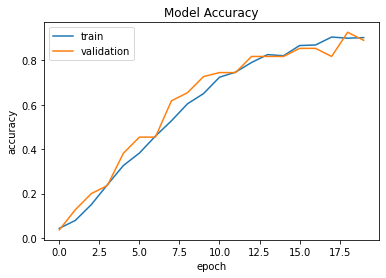

In [31]:
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

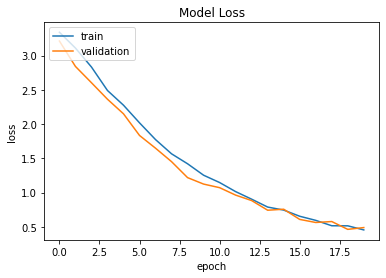

In [32]:
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## saving model

In [33]:
model1.save('../model/model1.h5') #cnn adam
model3.save('../model/model3.h5') #cnn rmsprop
mobilenetV2_model.save('../model/mobilenetV2_model.h5') #mobilenetV2 rmsprop
mobilenetV2_model2.save('../model/mobilenetV2_model2.h5') #mobilenetV2 adam


## load model

In [34]:
model1 = tf.keras.models.load_model('../model/model1.h5') #cnn adam
model2 = tf.keras.models.load_model('../model/model3.h5') #cnn rmsprop
model3 = tf.keras.models.load_model('../model/mobilenetV2_model.h5') #mobilenetV2 rmsprop
model4 = tf.keras.models.load_model('../model/mobilenetV2_model2.h5') #mobilenetV2 adam


Evaluation

In [35]:
model1.evaluate(validation_generator)

1/1 [==============================] - 1s 1s/step - loss: 0.3952 - accuracy: 0.8545


[0.39522379636764526, 0.8545454740524292]

In [36]:
model2.evaluate(validation_generator)

1/1 [==============================] - 1s 1s/step - loss: 0.2284 - accuracy: 0.9273


[0.22839197516441345, 0.9272727370262146]

In [37]:
model3.evaluate(validation_generator)

1/1 [==============================] - 3s 3s/step - loss: 0.6774 - accuracy: 0.8000


[0.6774252653121948, 0.800000011920929]

In [38]:
model4.evaluate(validation_generator)

1/1 [==============================] - 3s 3s/step - loss: 0.4888 - accuracy: 0.8909


[0.4887571632862091, 0.8909090757369995]

### model 1

In [39]:
eva_model1 = model1.predict(validation_generator)
C1 = confusion_matrix(validation_generator.classes, np.argmax(eva_model1, axis=1))
print(C1)

[[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 

In [40]:
y_pred1 = model1.predict(validation_generator, verbose=1)
y_pred1 = np.argmax(y_pred1, axis=1)
print(accuracy_score(validation_generator.classes, y_pred1))

1/1 [==============================] - 1s 961ms/step
0.8545454545454545


### model 2

In [41]:
eva_model2= model2.predict(validation_generator)
C2 = confusion_matrix(validation_generator.classes, np.argmax(eva_model2, axis=1))
print(C2)

[[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 

In [42]:
y_pred2 = model2.predict(validation_generator, verbose=1)
y_pred2 = np.argmax(y_pred2, axis=1)
print(accuracy_score(validation_generator.classes, y_pred2))

1/1 [==============================] - 1s 964ms/step
0.9272727272727272


### model3

In [43]:
eva_model3 = model3.predict(validation_generator)
C3 = confusion_matrix(validation_generator.classes, np.argmax(eva_model3, axis=1))
print(C3)

[[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 0 

In [44]:
y_pred3 = model3.predict(validation_generator, verbose=1)
y_pred3 = np.argmax(y_pred3, axis=1)
print(accuracy_score(validation_generator.classes, y_pred3))

1/1 [==============================] - 1s 1s/step
0.8


### model4

In [45]:
eva_model4 = model4.predict(validation_generator)
C4 = confusion_matrix(validation_generator.classes, np.argmax(eva_model4, axis=1))
print(C4)

[[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 

In [46]:
y_pred4 = model4.predict(validation_generator, verbose=1)
y_pred4 = np.argmax(y_pred4, axis=1)
print(accuracy_score(validation_generator.classes, y_pred4))

1/1 [==============================] - 1s 1s/step
0.8909090909090909
